In [496]:
import pandas as pd
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [376]:
# Import data
fp_data = Path.cwd()
file_path = fp_data/ 'data_processed.csv'
df = pd.read_csv(file_path)

# Create X variables as description, title and other variables
X_des = df['proc_be']
X_tit = df['proc_ti']
X_num = df.drop(columns = ['Forfatter', 'Titel', 'beskrivelse', 'proc_be', 'proc_ti', 'Stjerner'])
# remember to include dummy for gender

# Create y variable as average ratings 
y = df['Stjerner']

In [377]:
# Split into development (2/3) and test data (1/3)
X_dev_tit, X_test_tit, y_dev, y_test = train_test_split(X_tit, y, test_size=1/3, random_state=1234)
X_dev_des, X_test_des = train_test_split(X_des, test_size=1/3, random_state=1234)
X_dev_num, X_test_num = train_test_split(X_num, test_size=1/3, random_state=1234)

## Lasso

In [378]:
# Hyperparameter list for all X's 
lambdas = np.logspace(-4, 4, 10)
degrees = [1,2]

In [379]:
# Pipeline for processed titles and description
pipe_words_las = make_pipeline(TfidfVectorizer(),
    Lasso(random_state=1234))

# param grid used for titles and description
param_words_las = {'lasso__alpha': lambdas}
   
# Gridsearch for processed titles and description
search_lasso_title = GridSearchCV(pipe_words_las, param_words_las, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)
search_lasso_des = GridSearchCV(pipe_words_las, param_words_las, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)

In [380]:
# Pipeline for numerical variables
pipe_num_las = make_pipeline(PolynomialFeatures(include_bias=True),
    StandardScaler(),
    Lasso(random_state=1234))

# param grid used for titles and description
param_num_las = {'polynomialfeatures__degree': degrees,
            'lasso__alpha': lambdas}

# Gridsearch for numerical variables
search_lasso_num = GridSearchCV(pipe_num_las, param_num_las, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)

In [381]:
# append result to a list
las_result = []

# Fit title words
search_lasso_title.fit(X_dev_tit, y_dev)
las_result.append(search_lasso_title)

# Fit description words
search_lasso_des.fit(X_dev_des, y_dev)
las_result.append(search_lasso_des)

# Fit numerical values
search_lasso_num.fit(X_dev_num, y_dev)
las_result.append(search_lasso_num)

In [382]:
las_models = ['Lasso_title', 'Lasso_des', 'Lasso_num']
las_dataset = [X_dev_tit, X_dev_des, X_dev_num]
accu_las = []
mse_las = []
para_las = []

for i, name in enumerate(las_models):
    mse_l = -las_result[i].best_score_
    mse_las.append(mse_l)
    
    y_hat = las_result[i].predict(las_dataset[i])
    accuracy = np.mean(y_dev.round(1)==y_hat.round(1))
    accu_las.append(accuracy)
                    
    para = las_result[i].best_params_
    para_las.append(para)
    
    print(f'{name} Best parameter set: {para}', 
          f'Best mse: {mse_l}',
          f'Best accuracy: {accuracy}')

Lasso_title Best parameter set: {'lasso__alpha': 0.046415888336127774} Best mse: 0.06308174189814815 Best accuracy: 0.125
Lasso_des Best parameter set: {'lasso__alpha': 0.046415888336127774} Best mse: 0.06308174189814815 Best accuracy: 0.125
Lasso_num Best parameter set: {'lasso__alpha': 0.005994842503189409, 'polynomialfeatures__degree': 1} Best mse: 0.061796347644285654 Best accuracy: 0.1388888888888889


## Elasticnet

In [383]:
# Hyperparameter list for all X's 
lambdas = np.logspace(-4, 4, 10)
degrees = [1,2]
ela__l1_ratio = np.linspace(0, 1, 10)

In [384]:
# Pipeline for processed titles and description
pipe_words_elas = make_pipeline(TfidfVectorizer(),
                                ElasticNet(random_state=1234))

# param grid used for titles and description
param_words_elas = {'elasticnet__alpha': lambdas,
                   'elasticnet__l1_ratio': ela__l1_ratio}
   
# Gridsearch for processed titles and description
search_elas_title = GridSearchCV(pipe_words_elas, param_words_elas, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)
search_elas_des = GridSearchCV(pipe_words_elas, param_words_elas, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)

In [385]:
# Pipeline for numerical variables
pipe_num_ela = make_pipeline(PolynomialFeatures(include_bias=True),
    StandardScaler(),
    ElasticNet(random_state=1234))

# param grid used for titles and description
param_num_ela = {'polynomialfeatures__degree': degrees,
                'elasticnet__alpha': lambdas,
                'elasticnet__l1_ratio': ela__l1_ratio}

# Gridsearch for numerical variables
search_elas_num = GridSearchCV(pipe_num_ela, param_num_ela, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)

In [386]:
# append result to a list
elastic_result = []

# Fit title words
search_elas_title.fit(X_dev_tit, y_dev)
elastic_result.append(search_elas_title)

# Fit description words
search_elas_des.fit(X_dev_des, y_dev)
elastic_result.append(search_elas_des)

# Fit numerical values
search_elas_num.fit(X_dev_num, y_dev)
elastic_result.append(search_elas_num)

In [387]:
elas_models = ['Elastic_title', 'Elastic_des', 'Elastic_num']
elas_dataset = [X_dev_tit, X_dev_des, X_dev_num]
accu_elas = []
mse_elas = []
para_elas = []

for i, name in enumerate(elas_models):
    mse_e = -elastic_result[i].best_score_
    mse_elas.append(mse_e)
    
    y_hat = elastic_result[i].predict(elas_dataset[i])
    accuracy = np.mean(y_dev.round(1)==y_hat.round(1))
    accu_elas.append(accuracy)
                    
    para = elastic_result[i].best_params_
    para_elas.append(para)
    
    print(f'{name} Best parameter set: {para}', 
          f'Best mse: {mse_e}',
          f'Best accuracy: {accuracy}')                  

Elastic_title Best parameter set: {'elasticnet__alpha': 0.046415888336127774, 'elasticnet__l1_ratio': 0.0} Best mse: 0.060691008197316175 Best accuracy: 0.19444444444444445
Elastic_des Best parameter set: {'elasticnet__alpha': 0.000774263682681127, 'elasticnet__l1_ratio': 0.0} Best mse: 0.05600052327733716 Best accuracy: 0.9166666666666666
Elastic_num Best parameter set: {'elasticnet__alpha': 0.046415888336127774, 'elasticnet__l1_ratio': 0.5555555555555556, 'polynomialfeatures__degree': 2} Best mse: 0.059699460661979835 Best accuracy: 0.125


## OLS

In [388]:
# Hyperparameter list for all X's 
degrees = [1,2]

In [389]:
# Pipeline for processed titles and description
pipe_words_ols = make_pipeline(TfidfVectorizer(),
                                LinearRegression())

In [390]:
# Pipeline for numerical variables
pipe_num_ols = make_pipeline(PolynomialFeatures(include_bias=True),
    StandardScaler(),
    LinearRegression())

# param grid used for titles and description
param_num_ols = {'polynomialfeatures__degree': degrees}

# Gridsearch for numerical variables
search_ols_num = GridSearchCV(pipe_num_ols, param_num_ols, scoring='neg_mean_squared_error', cv=3,  return_train_score=True)

In [391]:
# Fit title words
pipe_words_ols.fit(X_dev_tit, y_dev)

# Fit description words
pipe_words_ols.fit(X_dev_des, y_dev)

# Fit numerical values
search_ols_num.fit(X_dev_num, y_dev)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [1, 2]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [392]:
accu_ols = []
mse_ols = []

# Words: 
y_hat_tit = pipe_words_ols.predict(X_dev_tit)
MSE_tit = mse(y_hat_tit,y_dev)
accuracy_tit =  np.mean(y_dev.round(1)==y_hat_tit.round(1)) 

y_hat_des = pipe_words_ols.predict(X_dev_des)
MSE_des = mse(y_hat_des,y_dev)
accuracy_des =  np.mean(y_dev.round(1)==y_hat_des.round(1)) 

#numerical variables

y_hat_num = search_ols_num.predict(X_dev_num)
MSE_num = -search_ols_num.best_score_
accuracy_num = np.mean(y_dev.round(1)==y_hat_num.round(1))

#Append MSE and accuracy to list
mse_ols.append(MSE_tit)
mse_ols.append(MSE_des)
mse_ols.append(MSE_num)

accu_ols.append(accuracy_tit)
accu_ols.append(accuracy_des)
accu_ols.append(accuracy_num)

para_ols = search_ols_num.best_params_ #dictionary

ols_models = ['OLS_title', 'OLS_des', 'OLS_num']

for i, name in enumerate(ols_models):
    print(f'{name}Best mse: {mse_ols[i]}',
          f'Best accuracy: {accu_ols[i]}')
    
print(f'{ols_models[2]} Best parameter set: {search_ols_num.best_params_}')


OLS_titleBest mse: 0.039754611655284 Best accuracy: 0.125
OLS_desBest mse: 9.660083149930282e-17 Best accuracy: 0.9444444444444444
OLS_numBest mse: 0.06527789889469714 Best accuracy: 0.1388888888888889
OLS_num Best parameter set: {'polynomialfeatures__degree': 1}


## Lasso - test

In [414]:
#Title pipeline
pipe_tit_las_best = make_pipeline(TfidfVectorizer(),
    Lasso(alpha = para_las[0]['lasso__alpha'], random_state=1234))

#Description pipeline
pipe_des_las_best = make_pipeline(TfidfVectorizer(),
    Lasso(alpha = para_las[1]['lasso__alpha'], random_state=1234))

#Numerical pipeline
pipe_num_las_best = make_pipeline(
    PolynomialFeatures(degree = para_las[2]['polynomialfeatures__degree'], include_bias=True),
    StandardScaler(),
    Lasso(alpha = para_las[2]['lasso__alpha'], random_state=1234))


In [415]:
#Fit to training data
# Fit title words
pipe_tit_las_best.fit(X_dev_tit, y_dev)

# Fit description words
pipe_des_las_best.fit(X_dev_des, y_dev)

# Fit numerical values
pipe_num_las_best.fit(X_dev_num, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0.005994842503189409, random_state=1234))])

In [416]:
#Predict on test data
accu_las_test = []
mse_las_test = []

# Words: 
y_hat_tit_test_las = pipe_tit_las_best.predict(X_test_tit)
MSE_tit_test_las = mse(y_hat_tit_test_las,y_test)
accuracy_tit_test_las =  np.mean(y_test.round(1)==y_hat_tit_test_las.round(1)) 

y_hat_des_test_las = pipe_des_las_best.predict(X_test_des)
MSE_des_test_las = mse(y_hat_des_test_las,y_test)
accuracy_des_test_las =  np.mean(y_test.round(1)==y_hat_des_test_las.round(1)) 

#numerical variables

y_hat_num_test_las = pipe_num_las_best.predict(X_test_num)
MSE_num_test_las = mse(y_hat_num_test_las,y_test)
accuracy_num_test_las =  np.mean(y_test.round(1)==y_hat_num_test_las.round(1)) 

#Append MSE and accuracy to list
mse_las_test.append(MSE_tit_test_las)
mse_las_test.append(MSE_des_test_las)
mse_las_test.append(MSE_num_test_las)

accu_las_test.append(accuracy_tit_test_las)
accu_las_test.append(accuracy_des_test_las)
accu_las_test.append(accuracy_num_test_las)

print(accu_las_test, mse_las_test)

[0.1111111111111111, 0.1111111111111111, 0.16666666666666666] [0.07698541666666667, 0.07698541666666667, 0.07545237370030004]


## Elastic net - test

In [417]:
#Title pipeline
pipe_tit_elas_best = make_pipeline(TfidfVectorizer(),
    ElasticNet(alpha = para_elas[0]['elasticnet__alpha'], 
               l1_ratio  = para_elas[0]['elasticnet__l1_ratio'], 
               random_state=1234)
                                  )

#Description pipeline
pipe_des_elas_best = make_pipeline(TfidfVectorizer(),
    ElasticNet(alpha = para_elas[1]['elasticnet__alpha'], 
               l1_ratio  = para_elas[1]['elasticnet__l1_ratio'], 
               random_state=1234)
                                  )

#Numerical pipeline
pipe_num_elas_best = make_pipeline(
    PolynomialFeatures(degree = para_elas[2]['polynomialfeatures__degree'], include_bias=True),
    StandardScaler(),
    ElasticNet(alpha = para_elas[2]['elasticnet__alpha'], 
               l1_ratio  = para_elas[2]['elasticnet__l1_ratio'], 
               random_state=1234)
                                    )

In [418]:
# Fit on training data
# Fit title words
pipe_tit_elas_best.fit(X_dev_tit, y_dev)

# Fit description words
pipe_des_elas_best.fit(X_dev_des, y_dev)

# Fit numerical values
pipe_num_elas_best.fit(X_dev_num, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.046415888336127774,
                            l1_ratio=0.5555555555555556, random_state=1234))])

In [419]:
#Predict test data
accu_elas_test = []
mse_elas_test = []

# Words: 
y_hat_tit_test_elas = pipe_tit_elas_best.predict(X_test_tit)
MSE_tit_test_elas = mse(y_hat_tit_test_elas,y_test)
accuracy_tit_test_elas =  np.mean(y_test.round(1)==y_hat_tit_test_elas.round(1)) 

y_hat_des_test_elas = pipe_des_elas_best.predict(X_test_des)
MSE_des_test_elas = mse(y_hat_des_test_elas,y_test)
accuracy_des_test_elas =  np.mean(y_test.round(1)==y_hat_des_test_elas.round(1)) 

#numerical variables

y_hat_num_test_elas = pipe_num_elas_best.predict(X_test_num)
MSE_num_test_elas = mse(y_hat_num_test_elas,y_test)
accuracy_num_test_elas =  np.mean(y_test.round(1)==y_hat_num_test_elas.round(1)) 

#Append MSE and accuracy to list
mse_elas_test.append(MSE_tit_test_elas)
mse_elas_test.append(MSE_des_test_elas)
mse_elas_test.append(MSE_num_test_elas)

accu_elas_test.append(accuracy_tit_test_elas)
accu_elas_test.append(accuracy_des_test_elas)
accu_elas_test.append(accuracy_num_test_elas)

print(accu_elas_test, mse_elas_test)

[0.1111111111111111, 0.1388888888888889, 0.1111111111111111] [0.07931625960274152, 0.07973729900887663, 0.07621951485177508]


## OLS - test

In [420]:
#Title pipeline
pipe_tit_ols_best = make_pipeline(TfidfVectorizer(),
                                LinearRegression())

#Description pipeline
pipe_des_ols_best = make_pipeline(TfidfVectorizer(),
                                LinearRegression())

#Numerical pipeline
pipe_num_ols_best = make_pipeline(
                            PolynomialFeatures(degree =para_ols['polynomialfeatures__degree'], include_bias=True),
                            StandardScaler(),
                            LinearRegression())

In [421]:
# Fit on training data
# Fit title words
pipe_tit_ols_best.fit(X_dev_tit, y_dev)

# Fit description words
pipe_des_ols_best.fit(X_dev_des, y_dev)

# Fit numerical values
pipe_num_ols_best.fit(X_dev_num, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [422]:
#Predict test data
accu_ols_test = []
mse_ols_test = []

# Words: 
y_hat_tit_test_ols = pipe_tit_elas_best.predict(X_test_tit)
MSE_tit_test_ols = mse(y_hat_tit_test_ols,y_test)
accuracy_tit_test_ols =  np.mean(y_test.round(1)==y_hat_tit_test_ols.round(1)) 

y_hat_des_test_ols = pipe_des_elas_best.predict(X_test_des)
MSE_des_test_ols = mse(y_hat_des_test_ols,y_test)
accuracy_des_test_ols =  np.mean(y_test.round(1)==y_hat_des_test_ols.round(1)) 

#numerical variables

y_hat_num_test_ols = pipe_num_elas_best.predict(X_test_num)
MSE_num_test_ols = mse(y_hat_num_test_ols,y_test)
accuracy_num_test_ols =  np.mean(y_test.round(1)==y_hat_num_test_ols.round(1)) 

#Append MSE and accuracy to list
mse_ols_test.append(MSE_tit_test_ols)
mse_ols_test.append(MSE_des_test_ols)
mse_ols_test.append(MSE_num_test_ols)

accu_ols_test.append(accuracy_tit_test_ols)
accu_ols_test.append(accuracy_des_test_ols)
accu_ols_test.append(accuracy_num_test_ols)

print(accu_ols_test, mse_ols_test)

[0.1111111111111111, 0.1388888888888889, 0.1111111111111111] [0.07931625960274152, 0.07973729900887663, 0.07621951485177508]


## Learning curves

In [484]:
#Lists
x_data = [X_dev_tit, X_dev_des, X_dev_num]
Title = ['title', 'description', 'numerical variables']

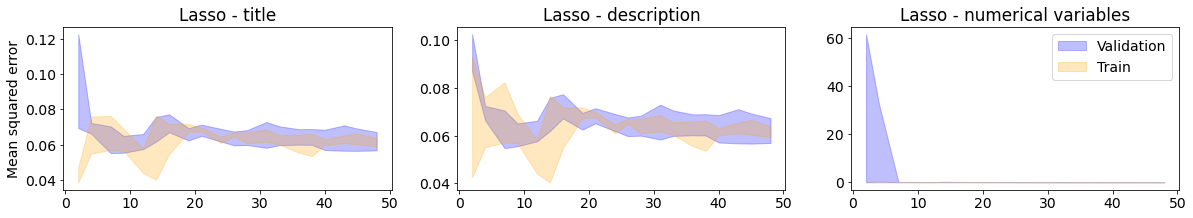

In [499]:
#Lasso
best_pipeline_lasso = [pipe_tit_las_best, pipe_des_las_best, pipe_num_las_best]

f_lasso, ax1 = plt.subplots(1, 3, figsize=(20,3))

for i, model1 in enumerate(best_pipeline_lasso):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=model1,
                   X=x_data[i],
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
    ax1[i].fill_between(train_sizes, -test_scores.min(1), -test_scores.max(1), alpha=0.25, label ='Validation', color='blue')
    ax1[i].fill_between(train_sizes, -train_scores.min(1), -train_scores.max(1),  alpha=0.25, label='Train', color='orange')

    ax1[i].set_title(f'Lasso - {Title[i]}')

ax1[0].set_ylabel('Mean squared error')
ax1[2].legend();

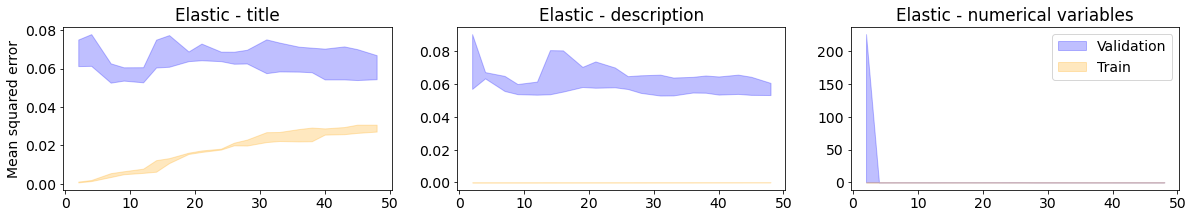

In [500]:
#Elastic net
best_pipeline_elastic = [pipe_tit_elas_best, pipe_des_elas_best, pipe_num_elas_best]

f_elas, ax2 = plt.subplots(1, 3, figsize=(20,3))

for j, model2 in enumerate(best_pipeline_elastic):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=model2,
                   X=x_data[j],
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
    ax2[j].fill_between(train_sizes, -test_scores.min(1), -test_scores.max(1), alpha=0.25, label ='Validation', color='blue')
    ax2[j].fill_between(train_sizes, -train_scores.min(1), -train_scores.max(1),  alpha=0.25, label='Train', color='orange')

    ax2[j].set_title(f'Elastic - {Title[j]}')

ax2[0].set_ylabel('Mean squared error')
ax2[2].legend();

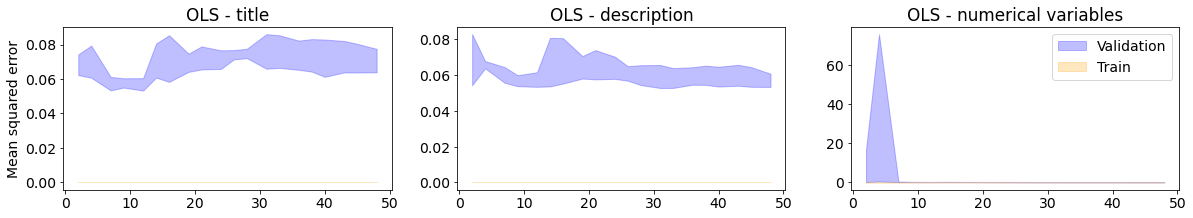

In [501]:
#OLS
best_pipeline_ols = [pipe_tit_ols_best, pipe_des_ols_best, pipe_num_ols_best]

f_ols, ax3 = plt.subplots(1, 3, figsize=(20,3))

for k, model3 in enumerate(best_pipeline_ols):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=model3,
                   X=x_data[k],
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
    ax3[k].fill_between(train_sizes, -test_scores.min(1), -test_scores.max(1), alpha=0.25, label ='Validation', color='blue')
    ax3[k].fill_between(train_sizes, -train_scores.min(1), -train_scores.max(1),  alpha=0.25, label='Train', color='orange')

    ax3[k].set_title(f'OLS - {Title[k]}')

ax3[0].set_ylabel('Mean squared error')
ax3[2].legend();

## Validation curves

In [ ]:
#Lists
x_data = [X_dev_tit, X_dev_des, X_dev_num]
Title = ['title', 'description', 'numerical variables']

lambda
0.046416    0.063082
Name: Validation - title, dtype: float64
lambda
0.046416    0.063082
Name: Validation - description, dtype: float64
lambda
0.005995    0.061796
Name: Validation - numerical variables, dtype: float64


,Train - title,Validation - title,Train - description,Validation - description,Train - numerical variables,Validation - numerical variables
lambda,,,,,,
0.000100,0.000079,0.082192,0.000154,0.072060,0.055870,0.065015
0.000774,0.003959,0.076593,0.007688,0.063288,0.055982,0.063422
0.005995,0.056845,0.067127,0.060817,0.063085,0.056576,0.061796
0.046416,0.060826,0.063082,0.060826,0.063082,0.059158,0.062934
0.359381,0.060826,0.063082,0.060826,0.063082,0.060826,0.063082
2.782559,0.060826,0.063082,0.060826,0.063082,0.060826,0.063082
21.544347,0.060826,0.063082,0.060826,0.063082,0.060826,0.063082
166.810054,0.060826,0.063082,0.060826,0.063082,0.060826,0.063082
1291.549665,0.060826,0.063082,0.060826,0.063082,0.060826,0.063082


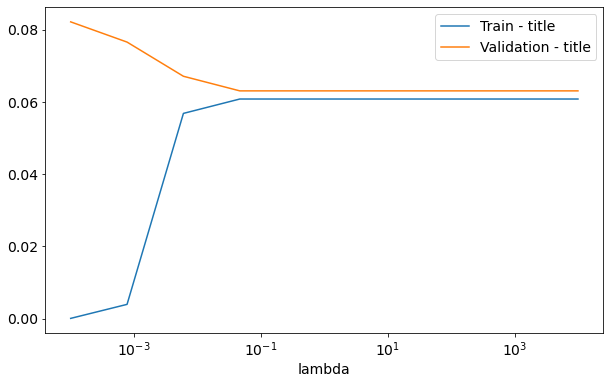

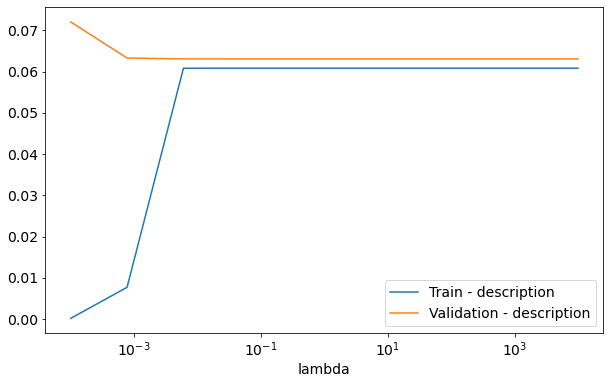

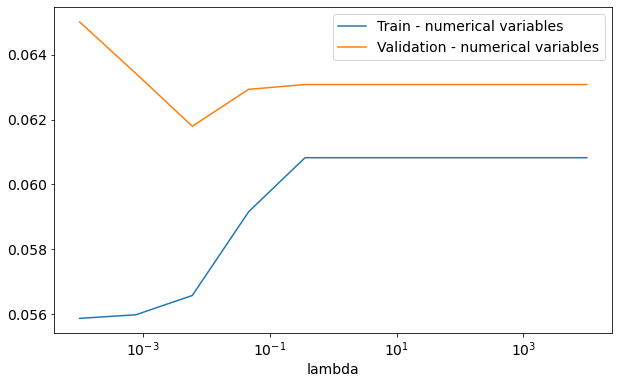

In [554]:
#Lasso
best_pipeline_lasso = [pipe_tit_las_best, pipe_des_las_best, pipe_num_las_best]

results_lasso_df = pd.DataFrame()

for i, model in enumerate(best_pipeline_lasso):

    train_scores, test_scores = \
        validation_curve(estimator=model,
                     X=x_data[i],
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=3)

    # OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
    mse_score = pd.DataFrame({'lambda':lambdas,
                              f'Train - {Title[i]}':-train_scores.mean(axis=1),
                              f'Validation - {Title[i]}':-test_scores.mean(axis=1)})\
                              .set_index('lambda')   
    
    results_lasso_df = pd.concat([results_lasso_df, mse_score], axis=1)
    print(mse_score[f'Validation - {Title[i]}'].nsmallest(1))
    
    mse_score.plot(logx=True, figsize=(10,6));

results_lasso_df

In [556]:
#Polynomial features - lasso (num)
train_scores, test_scores = \
    validation_curve(estimator=pipe_num_las_best,
                     X=X_dev_num,
                     y=y_dev,
                     param_name='polynomialfeatures__degree', #built-in name of hyperparameter
                     param_range=degrees, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=3)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score_num_las = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'poly':degrees})\
              .set_index('poly')   
print(mse_score_num_las.Validation.nsmallest(1))

mse_score_num_las

poly
1    0.061796
Name: Validation, dtype: float64


,Train,Validation
poly,,
1,0.056576,0.061796
2,0.054604,0.078696


In [557]:
#Polynomial features - OLS (num)
train_scores, test_scores = \
    validation_curve(estimator=pipe_num_ols_best,
                     X=X_dev_num,
                     y=y_dev,
                     param_name='polynomialfeatures__degree', #built-in name of hyperparameter
                     param_range=degrees, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=3)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score_num_ols = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'poly':degrees})\
              .set_index('poly')   
print(mse_score_num_ols.Validation.nsmallest(1))

mse_score_num_ols

poly
1    0.065278
Name: Validation, dtype: float64


,Train,Validation
poly,,
1,0.055868,0.065278
2,0.044895,1.015466
